In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt
from proofreader.utils.vis import plot_3d
import torch
%load_ext autoreload
%autoreload 2
%matplotlib inline

def plot_example(x,y=None,title=None, lim=0.1):
    lim = (lim*-1,lim)
    lim = (lim,lim,lim)
    pc = np.swapaxes(x, 0, 1)
    t = ''
    if y is not None:
        t = y.item() == 1
    if title is not None:
        t = title
    plot_3d(pc, title=t, lims=lim)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
from proofreader.data.cremi import prepare_cremi_vols

train_vols, test_vols = prepare_cremi_vols('../../dataset/cremi')

AssertionError: 

In [ ]:
from proofreader.data.splitter import NeuriteDataset
from proofreader.data.augment import Augmentor
num_slices = [4, 4]
radius = 96
context_slices = 4
num_points = 1024

augmentor = Augmentor(center=True, shuffle=True, normalize=[125, 1250, 1250])
train_dataset = NeuriteDataset(test_vols, num_slices, radius, context_slices, num_points=num_points, torch=True, open_vol=True, verbose=False, Augmentor=augmentor)
print(len(train_dataset))

In [ ]:
from torch.utils.data import DataLoader
import torch.nn as nn
config = get_config('cn_context_4_aug_small')
dataloader = DataLoader(dataset=train_dataset, batch_size=2, shuffle=True)
model, _ ,_ = build_full_model_from_config(config.model, config.dataset)
model = nn.DataParallel(model)
model = load_model(model, '../../330.ckpt', map_location=torch.device('cpu'))



In [ ]:
from proofreader.model.classifier import *
with torch.no_grad():
    count, acc = 0,0
    for step, batch in enumerate(dataloader):
        count += 1
        # get batch
        x, y = batch
        y_hat = model(x)
        pred = predict_class(y_hat)
        accs = get_accuracy(y, pred)
        print(accs)
        acc += accs['total_acc']
        print(round(acc/count, 3))


In [ ]:
from proofreader.data.augment import Augmentor
from proofreader.utils.torch import load_model
from proofreader.model.config import *
from proofreader.model.classifier import *
from torch.utils.data import DataLoader
import torch.nn as nn

config = get_config('pointnet-pre-cs2')
ds_config = config.dataset

model = PointNet(num_points=2000, classes=2, batch_norm=True)
model = nn.DataParallel(model)
model = load_model(model, '../../750.ckpt', map_location=torch.device('cpu'))

augmentor = Augmentor(center=True, shuffle=True, normalize=[125, 1250, 1250])
num_slices = 1
tester = SliceDataset(test_vols, num_slices, 96, 2, 
                    num_points=2000, Augmentor=augmentor, verbose=False, drop_false=True, candidate_group=True, randomize=True)


In [ ]:

with torch.no_grad():
    model.eval()
    neurites = 0
    seen = 0
    seen_correct = 0
    neurite_correct = 0
    for step, batch in enumerate(tester):
      
        # get batch
        x, y = batch

        for i in range(x.shape[0]): 
            y_hat = model(x[i].unsqueeze(dim=0))
            pred = predict_class(y_hat)
            true = int(pred == y[i])
            seen_correct += true
            seen += 1
            
            if pred == 1 or y[i] == 1:
                neurites += 1
                neurite_correct += true
                # if true == 0:
                #     plot_example(x[i],y[i])
                break

        if step % 10 == 0:
            print('seen acc:', seen_correct/seen, 'neurite acc:', neurite_correct/neurites)
            print(tester.get_stats())
        if step > 1000:
            break

print('seen acc:', seen_correct/seen)
print('neurite acc:', neurite_correct/neurites)
print(tester.get_stats())


In [35]:
import torch
from proofreader.utils.vis import *
import numpy as np

# for i in range(1,6):
#     print('NUM SLICES: ', i)
path = f'/mnt/home/jberman/ceph/pf/dataset/ns=3_r=128_cs=2_np=2048_dataset_test.pt'
X, Y = torch.load(f'{path}')


0 0.0
1 0.5709134615384616
2 0.146484375
3 0.07406850961538461
4 0.03470552884615385
5 0.021334134615384616
6 0.019381009615384616
7 0.016826923076923076
8 0.012469951923076924
9 0.008263221153846154
10 0.0078125
11 0.006911057692307692
12 0.007211538461538462
13 0.0078125
14 0.010667067307692308
4 0.11868990384615385


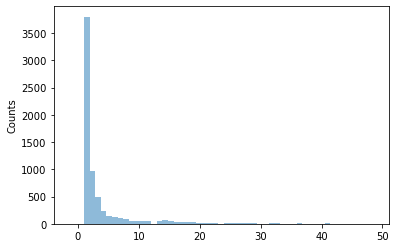

In [36]:
lens = []
for b in X:
    lens.append(len(b))
lens = np.array(lens)

# if Y[:,0][-1].item() != 1:
#     if Y[:,0].count_nonzero().item() != 0:
#         print(y[:,0])

cutoff = 8
p_sum = 0
for i in range(15):
    p = len(lens[lens==i])/len(lens)
    print(i, p)
    if i > cutoff:
        p_sum += p
print(cutoff, p_sum)
make_histogram(lens, bins=50)

In [ ]:
# reset batch id
ts = 0
total = 0
for y in Y:
    ts += y[:,0].count_nonzero().item()
    total += len(y[:,0])

print(ts, ts/total)

In [ ]:
from proofreader.model.config import *
# merge canidate batches for testset
# reset batch id
for i in range(len(X)):
    y = Y[i]
    y[:,1] = i

test_dataset_merged = SimpleDataset(torch.cat(X), torch.cat(Y), shuffle=True)


In [ ]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset=test_dataset_merged, batch_size=256, drop_last=False, shuffle=True)

In [ ]:
from proofreader.model.classifier import *
ys, preds, bids = [], [] ,[]

for step, batch in enumerate(dataloader):
    # get batch
    x, y = batch
    bid = y[:, 1]
    y = y[:, 0]

    pred = torch.zeros_like(y)
    ys.append(y)
    preds.append(pred)
    bids.append(bid)


ys, preds, bids = torch.cat(ys), torch.cat(preds), torch.cat(bids)

uids = np.unique(bids)
batch_acc = {'neurite_acc': 0, 'seen_acc': 0}
print(uids)
for uid in uids:
    idxs = bids == uid
    print(ys[idxs], preds[idxs])
    accs = get_accuracy(ys[idxs], preds[idxs], ret_perfect=True)
    batch_acc['neurite_acc'] += accs['perfect']
    batch_acc['seen_acc'] += (accs['total_acc']*len(ys[idxs]))


batch_acc['neurite_acc'] /= len(uids)
batch_acc['seen_acc'] /= len(test_dataset_merged)
print(len(uids), len(test_dataset_merged))
print(batch_acc)

In [ ]:
import random
import torch
W = torch.load(f'../../wrong.t')

In [ ]:
i = random.randint(0,len(W))
bx, by, bp = W[i]
print(i)
for j in range(len(bx)):
    title = f'pred: {bp[j]} true: {by[j]}'
    plot_example(bx[j],by[j],title=title)

In [ ]:
import torch
from proofreader.utils.vis import *
import numpy as np

# for i in range(1,6):
#     print('NUM SLICES: ', i)
path = f'/mnt/home/jberman/ceph/pf/dataset/ns=1_r=128_cs=2_np=2048_dataset_train.pt'
X, Y = torch.load(f'{path}')


In [ ]:
i = 0
scale_to = np.array([1.0,1.0,1.0])
for x,y in zip(X,Y):
    scaler = scale_to / np.amax(x.numpy(), axis=1)
    x[0,:] *= scaler[0]
    x[1,:] *= scaler[1]
    x[2,:] *= scaler[2]
    pc = np.swapaxes(x, 0, 1)
    plot_3d(pc)
    i += 1
    if i > 5:
        break

In [ ]:
print(X.shape)
print()


In [ ]:
unique_z = np.unique(X[:,0,:])

In [ ]:
for z in unique_z:
    indices = X[:,0,:] == z
    indices = np.any(indices.numpy(), axis=1, keepdims=True).squeeze()
    print(z, X[indices].shape)


In [ ]:
indices = X[:,0,:] == -0.003999999 
indices = np.any(indices.numpy(), axis=1, keepdims=True).squeeze()

for x,y in zip(X[indices],Y[indices]):
    print(np.unique(x[0]))
    print(y)
    plot_example(x,y=y[0])

In [2]:
from proofreader.data.cremi import *
path = '/mnt/home/jberman/sc/proofreader/dataset/cremi'
trueA = read_cremi_volume('A', seg=True, path=path)
trueB = read_cremi_volume('B', seg=True, path=path)
trueC = read_cremi_volume('C', seg=True, path=path)

# A is clean
trueA_test = trueA[:16].copy()
trueA_train = trueA[16:].copy()

trueB_test = trueB[:16].copy()
trueB_train = trueB[16:].copy()


In [133]:
from proofreader.data.augment import Augmentor
from proofreader.data.splitter import SliceDataset
num_slices = 1
radius = 96
context_slices = 3
num_points = 2048
scale = 1000
z_amt = (context_slices*2+num_slices)-1
augmentor = Augmentor(center=True, shuffle=True,
                        normalize=(z_amt, scale, scale))
dataset = SliceDataset([trueB_train], num_slices, radius, context_slices, num_points=num_points, Augmentor=augmentor, truncate_candidates=0, candidate_group=False, scale=scale, verbose=False, allow_multiple=True)
itr = dataset.__iter__()

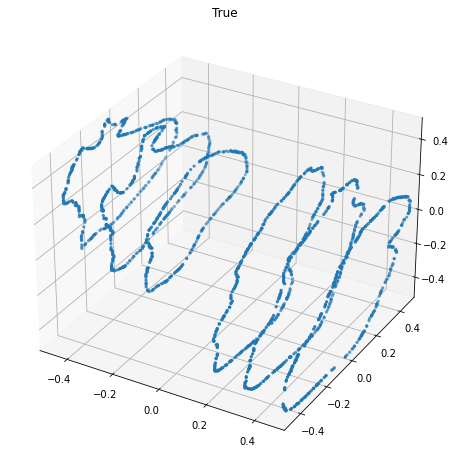

In [170]:
example = next(itr)
x, y = example
plot_example(x,y=y, lim=0.5)

In [155]:
print(x.shape)
print(torch.min(x[0]), torch.max(x[0]))
print(torch.min(x[1]), torch.max(x[1]))
print(torch.min(x[2]), torch.max(x[2]))

torch.Size([3, 2048])
tensor(-0.5000) tensor(0.5000)
tensor(-0.4990) tensor(0.4990)
tensor(-0.4990) tensor(0.4990)
